# Gradients (derivatives w.r.t. multiple parameters)
In this notebook we compute the gradients of the A- and D-OED utility functions with respect to both the radius and the speed flight path parameterization. We get the gradients just by stacking up the individual derivatives from the previous notebook, so by itself there isn't much to do here. Instead, we take this notebook as a chance to streamline the derivative computation somewhat to take out redundant computations.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats
from matplotlib import cm

tStart_notebook = time.time()

## User settings

In [2]:
meshDim = 100
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 5
n_search = 10
n_test = 50

eval_mode = "point-eval" # because it's faster for testing code

dt = 0.001
final_time = 4

## Setup
We stay with the stationary model for now. 

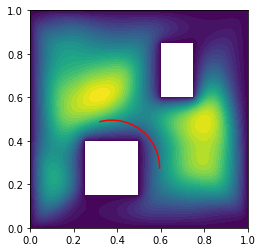

In [20]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
grid_t = np.arange(0, final_time+dt, dt)

para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_steadystate_true = fom.solve_steady(forcing=m)

# set default flying parameters
flying_parameters = {
                "radius" : radius_test,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : speed_test # 0.3
            }

drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)

prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))
noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01)
brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)

dl.plot(sol_steadystate_true, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

In [4]:
sol_steadystate = np.empty((n_para), dtype = object)

for i in range(n_para):
    m = fom.assemble_forcing(para=np.eye(n_para)[:, i])
    sol_steadystate[i] = fom.solve_steady(forcing=m)

## Functions

The main link between the utility function gradients and the flightpath parameterization is the derivative of the flightpath with respect to its parameters. In terms of our class distinctions, the corresponding function should be part of the `Drone` class - the drone is the only object that actually knows (or cares) what the parameters are and how they get translated into a flight path. When we switch out a flight path parameterization, we should only need to switch out the `Drone` subclass.

For our gradients here, let's assume the only two parameters are the speed and the radius (just as we've treated them previously), and in terms of a parameter vector they are ordered as `alpha = [speed, radius]`, i.e. speed first. 

We stack the derivatives horizontally such that the return value has size `<spatial dimension> x <number of control parameters>`

In [5]:
n_controls = 2

def d_position_d_control(t, flying_parameters = flying_parameters):
    # for the Drone class

    radius = flying_parameters["radius"]
    speed = flying_parameters["speed"]

    round_trip_time = 2 * np.pi * radius / speed
    angles = (t * 2 * np.pi) / round_trip_time

    d_speed = t * np.hstack([-np.sin(angles), np.cos(angles)]).T 

    d_radius = np.hstack([np.cos(angles), np.sin(angles)]).T 
    d_radius = d_radius - (t * speed) * np.hstack([-np.sin(angles), np.cos(angles)]).T / radius

    return np.vstack([d_speed, d_radius]).T


For the remaining parts I think we can merge a lot of stuff together, but we shouldn't force it. For once, I think the derivative of the measurements should again be part of the `Drone` class because of the distinction between different types of measurements. The spatial derivative of the state should be in the `FOM` class since it depends on how the problem is discretized.

In [6]:
def d_state_d_x():
    # goes into the FOM class
    
    Du = [dl.grad(sol_steadystate[i]) for i in range(n_para)]
    Du = [dl.project(Du[i]) for i in range(n_para)]
    
    # todo: include time dependence of the state
    
    return Du

In [7]:
# make sure to only compute these derivatives once
Du = d_state_d_x()

The size of the return for `d_measurement_d_control` is `n_para x <number of controls>`

In [8]:
def d_measurement_d_control(t, flying_parameters = flying_parameters):
    # goes into the Drone class
    
    position = drone.get_position(t=t, flying_parameters = flying_parameters)
    grad_p = d_position_d_control(t=t, flying_parameters = flying_parameters)
    # todo: should the drone here be the one initialized in d_PostCov_d_control?
    # todo: is the call to drone.get_position redundant with drone.get_trajectory in d_PostCov_d_control?
    
    Du_at_position = np.empty((2, n_para))
    
    if eval_mode == "point-eval":
        for i in range(n_para):
            Du_at_position[:, i] = Du[i](position)
    else:
        raise NotImplementedError("still need to do the maths for other measurement types")
        
    # todo: should the evaluation of Du at the flight path position be here or part of d_state_d_x already?
    # answer: I think we can only decide that once we know how the derivatives for the convolution type 
    # measurements look like
        
    return Du_at_position.T @ grad_p

Finally the part where I think we can merge the most parts together:

In [9]:
def d_PostCov_d_control(flying_parameters=flying_parameters):
    
    # initialization
    drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
    pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)
    
    BU = np.empty((grid_t.shape[0], n_para))
    for i in range(n_para):
        BU[:, i] = drone.measure(flightpath = pos, state=sol_steadystate[i])
        
    invCovBU = noise_model.apply_covar_inv(BU)
    invPostCov = BU.T @ invCovBU + prior.covar_inv
    
    # get derivative of inverse posterior covariance matrix
    dBU = np.empty((grid_t.shape[0], n_para, n_controls))
    for k in range(grid_t.shape[0]):
        dBU[k, :, :] = d_measurement_d_control(t=grid_t[k], flying_parameters=flying_parameters)
    
    d_invPostCov_d_speed = [dBU[:, :, i].T @ invCovBU + invCovBU.T @ dBU[:, :, i] for i in range(n_controls)]
    
    # sanity check:
    if len(d_invPostCov_d_speed[0].shape) == 0:
        #d_invPostCov_d_speed = np.array(np.array([d_invPostCov_d_speed]))
        
        # instead of casting into the correct format we raise an error, because at this point I expect the code
        # to be optimized enough that everything gets the correct shape just from being initialized correctly
        raise RuntimeError("invalid shape = {} for d_invPostCov_d_speed".format(d_invPostCov_d_speed[0].shape))
    
    PostCov = la.inv(invPostCov)
    derivative = [-PostCov @ d_invPostCov_d_speed[i] @ PostCov for i in range(n_controls)]
    # todo: I'm using la.inv here because I also want to return the matrix below. However, when we adapt this
    # into the source code we need to replace it with a proper linear system solve, maybe even just return 
    # the inverse posterior covarianc matrix
    
    return derivative, PostCov

Now it's time for the utility functions:

In [10]:
def d_utilA_d_control(flying_parameters=flying_parameters, bool_return_covar = True):
    
    # get derivative information of the posterior covariance function
    der, postCov = d_PostCov_d_control(flying_parameters=flying_parameters)
    
    # compute gradient
    gradient = np.hstack([np.trace(der[i]) for i in range(n_controls)])
    
    if bool_return_covar:
        return gradient, postCov
    
    return gradient

In [11]:
def d_utilD_d_control(flying_parameters=flying_parameters, bool_return_covar = True):
    
    # get derivative information of the posterior covariance function
    der, postCov = d_PostCov_d_control(flying_parameters=flying_parameters)
    
    # only compute the determinant once
    det = la.det(postCov)
    
    gradient = np.zeros((n_controls,))
    for i in range(n_controls):
        
        # sanity check
#         if len(der[i]) == 1:
#             raise RuntimeError("invalid shape = {} for derivative matrix".format(der[i].shape))
        
        # apply transposed cofactor matrix 
        yolo = det * la.solve(postCov.T, der[i])
        # todo: the decomposition cofactor(M) = det(M)*inv(M) only holds for invertible matrices M
        # I don't think the posterior covariance matrix can become singular unless the prior or the noise covariance
        # matrices are degenerate. We might want to catch that case though.
        
        # finish computing the gradient
        gradient[i] = np.trace(yolo)
        
    if bool_return_covar:
        return gradient, postCov
    
    return gradient

## Test

In [12]:
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275

vec_radius = np.linspace(radius_min, radius_max, n_test)
vec_speed = np.linspace(2*np.pi*radius_min/(360*final_time), 2*np.pi*radius_min/final_time, n_test)

utilA = np.zeros((n_test, n_test))
utilD = np.zeros((n_test, n_test))


for i in range(n_test):
    
    print("iteration i = ", i)
    
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]
    
    for j in range(n_test):
        
        flying_parameters_2["radius"] = vec_radius[j]
        
        __, postCov = d_utilA_d_control(flying_parameters = flying_parameters_2)
        utilA[j,i] = np.trace(postCov)
        utilD[j,i] = la.det(postCov)
        
        

iteration i =  0
iteration i =  1
iteration i =  2
iteration i =  3
iteration i =  4
iteration i =  5
iteration i =  6
iteration i =  7
iteration i =  8
iteration i =  9
iteration i =  10
iteration i =  11
iteration i =  12
iteration i =  13
iteration i =  14
iteration i =  15
iteration i =  16
iteration i =  17
iteration i =  18
iteration i =  19
iteration i =  20
iteration i =  21
iteration i =  22
iteration i =  23
iteration i =  24
iteration i =  25
iteration i =  26
iteration i =  27
iteration i =  28
iteration i =  29
iteration i =  30
iteration i =  31
iteration i =  32
iteration i =  33
iteration i =  34
iteration i =  35
iteration i =  36
iteration i =  37
iteration i =  38
iteration i =  39
iteration i =  40
iteration i =  41
iteration i =  42
iteration i =  43
iteration i =  44
iteration i =  45
iteration i =  46
iteration i =  47
iteration i =  48
iteration i =  49


In [13]:
speed_test = 0.1
radius_test = 0.22
n_test_2 = 100

vec_radius_2 = np.linspace(radius_min, radius_max, n_test_2)
vec_speed_2 = np.linspace(2*np.pi*radius_min/(360*final_time), 2*np.pi*radius_min/final_time, n_test_2)

flying_parameters_2 = flying_parameters.copy()
flying_parameters_2["speed"] = speed_test
flying_parameters_2["radius"] = radius_test

der_A, postCov = d_utilA_d_control(flying_parameters = flying_parameters_2)
val_A = np.trace(postCov)

der_D, postCov = d_utilD_d_control(flying_parameters = flying_parameters_2)
val_D = la.det(postCov)

utilA_r = np.zeros((n_test_2,))
utilD_r = np.zeros((n_test_2,))

utilA_s = np.zeros((n_test_2,))
utilD_s = np.zeros((n_test_2,))

for i in range(n_test_2):
    
    print("iteration i = ", i)
    
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed_2[i]
    flying_parameters_2["radius"] = radius_test
    
    __, postCov = d_utilA_d_control(flying_parameters = flying_parameters_2)
    utilA_r[i] = np.trace(postCov)
    utilD_r[i] = la.det(postCov)
    
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = speed_test
    flying_parameters_2["radius"] = vec_radius_2[i]
    
    __, postCov = d_utilA_d_control(flying_parameters = flying_parameters_2)
    utilA_s[i] = np.trace(postCov)
    utilD_s[i] = la.det(postCov)



iteration i =  0
iteration i =  1
iteration i =  2
iteration i =  3
iteration i =  4
iteration i =  5
iteration i =  6
iteration i =  7
iteration i =  8
iteration i =  9
iteration i =  10
iteration i =  11
iteration i =  12
iteration i =  13
iteration i =  14
iteration i =  15
iteration i =  16
iteration i =  17
iteration i =  18
iteration i =  19
iteration i =  20
iteration i =  21
iteration i =  22
iteration i =  23
iteration i =  24
iteration i =  25
iteration i =  26
iteration i =  27
iteration i =  28
iteration i =  29
iteration i =  30
iteration i =  31
iteration i =  32
iteration i =  33
iteration i =  34
iteration i =  35
iteration i =  36
iteration i =  37
iteration i =  38
iteration i =  39
iteration i =  40
iteration i =  41
iteration i =  42
iteration i =  43
iteration i =  44
iteration i =  45
iteration i =  46
iteration i =  47
iteration i =  48
iteration i =  49
iteration i =  50
iteration i =  51
iteration i =  52
iteration i =  53
iteration i =  54
iteration i =  55
it

/var/folders/_k/q9sdsmfx2j35cmp3z9tn84km0000gp/T/ipykernel_2512/182715695.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(test, shrink=1, aspect=10)


Text(0.5, 0, 'speed')

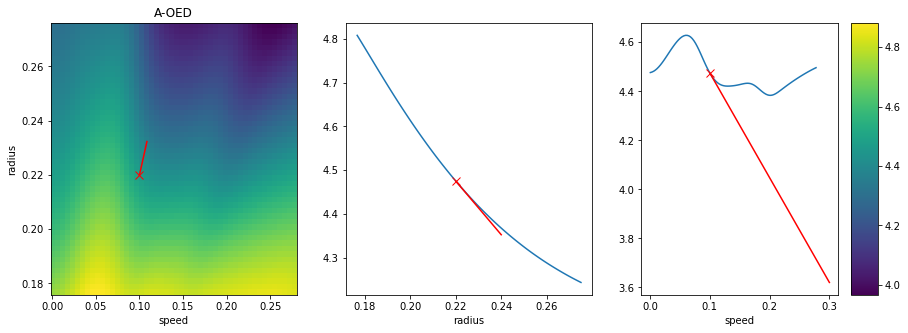

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

test = axs[0].pcolormesh(vec_speed, vec_radius, utilA)
fig.colorbar(test, shrink=1, aspect=10)

axs[0].plot([speed_test, speed_test - 0.002 * der_A[0]], 
        [radius_test, radius_test - 0.002 * der_A[1]], color="r")

axs[0].plot([speed_test], [radius_test], marker="x", markersize=8, color="r")

axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("A-OED")


axs[1].plot(vec_radius_2, utilA_s)
axs[1].plot([radius_test], val_A, marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + 0.02], [val_A, val_A+0.02*der_A[1]], marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed_2, utilA_r)
axs[2].plot([speed_test], val_A, marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + 0.2], [val_A, val_A+0.2*der_A[0]], marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")



/var/folders/_k/q9sdsmfx2j35cmp3z9tn84km0000gp/T/ipykernel_2512/4276484496.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(test, shrink=1, aspect=10)


Text(0.5, 0, 'speed')

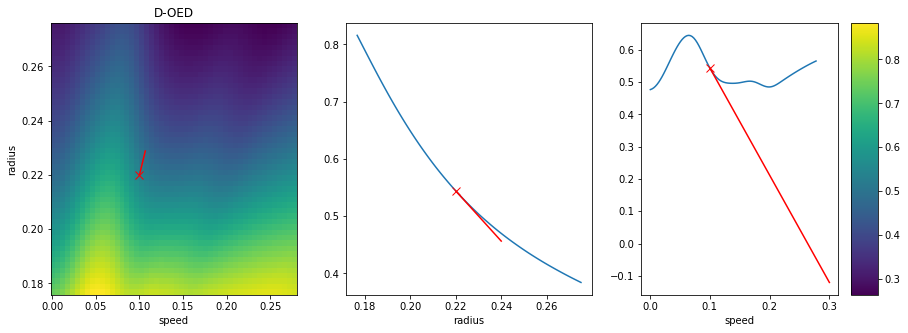

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

test = axs[0].pcolormesh(vec_speed, vec_radius, utilD)
fig.colorbar(test, shrink=1, aspect=10)

axs[0].plot([speed_test, speed_test - 0.002 * der_D[0]], 
        [radius_test, radius_test - 0.002 * der_D[1]], color="r")

axs[0].plot([speed_test], [radius_test], marker="x", markersize=8, color="r")

axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED")

axs[1].plot(vec_radius_2, utilD_s)
axs[1].plot([radius_test], val_D, marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + 0.02], [val_D, val_D+0.02*der_D[1]], marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed_2, utilD_r)
axs[2].plot([speed_test], val_D, marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + 0.2], [val_D, val_D+0.2*der_D[0]], marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")



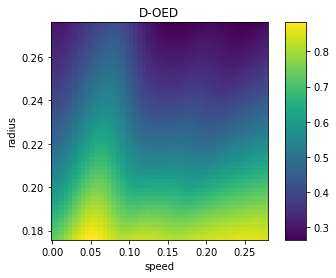

In [21]:
fig, ax = plt.subplots(1, 1)
axs = [ax]

scale = 0.02

test = axs[0].pcolormesh(vec_speed, vec_radius, utilD)
fig.colorbar(test, shrink=1, aspect=10)

# axs[0].plot([speed_test, speed_test - scale * der_D[0] / la.norm(der_D)], 
#         [radius_test, radius_test - scale * der_D[1]  / la.norm(der_D)], color="r")

# axs[0].plot([speed_test], [radius_test], marker="x", markersize=8, color="r")

# axs[0].plot([min(vec_speed), max(vec_speed)], 
#             [radius_test, radius_test], 
#             linestyle = '-', marker = None, color = 'k')

# axs[0].plot([speed_test, speed_test], 
#             [min(vec_radius), max(vec_radius)], 
#             linestyle = '-', marker = None, color = 'k')


axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED")
axs[0].set_box_aspect(1)

fig.savefig("D-OED_5parameters")

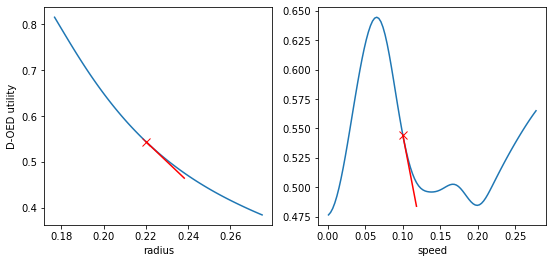

In [22]:
fig, axs_tmp = plt.subplots(1, 2, figsize = (9, 4))
scale = 0.1

axs = [0, axs_tmp[0], axs_tmp[1]]

axs[1].plot(vec_radius_2, utilD_s)
axs[1].plot([radius_test], val_D, marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale / la.norm(der_D)], [val_D, val_D+scale*der_D[1] / la.norm(der_D)], marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")
axs[1].set_ylabel("D-OED utility")

axs[2].plot(vec_speed_2, utilD_r)
axs[2].plot([speed_test], val_D, marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale / la.norm(der_D)], [val_D, val_D+scale*der_D[0] / la.norm(der_D)], marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

fig.savefig("derivatives_4")

Text(0.5, 1.0, 'D-ultility')

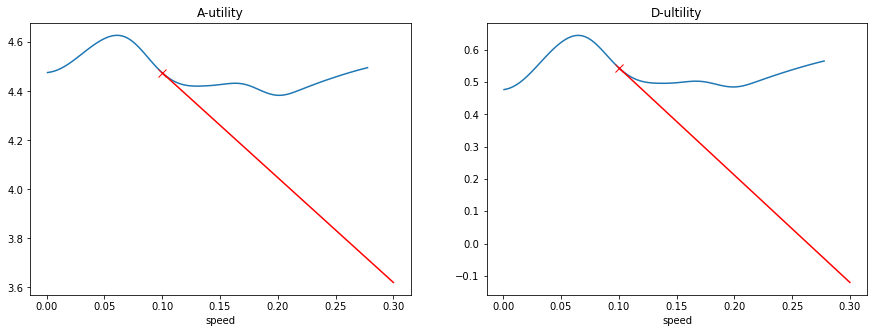

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(vec_speed_2, utilA_r)
axs[0].plot([speed_test], val_A, marker="x", markersize=8, color="r")
axs[0].plot([speed_test, speed_test + 0.2], [val_A, val_A+0.2*der_A[0]], marker="", markersize=8, color="r")
axs[0].set_xlabel("speed")
axs[0].set_title("A-utility")

axs[1].plot(vec_speed_2, utilD_r)
axs[1].plot([speed_test], val_D, marker="x", markersize=8, color="r")
axs[1].plot([speed_test, speed_test + 0.2], [val_D, val_D+0.2*der_D[0]], marker="", markersize=8, color="r")
axs[1].set_xlabel("speed")
axs[1].set_title("D-ultility")



**Welcome back!**
Next steps:
- get rid of _all_ calls to `la.inv`
- extend to time-dependent states (new notebook)
- merge into source code

## The End.

In [19]:
print("Runtime of this notebook: ", (time.time()-tStart_notebook)/60, " min.")

Runtime of this notebook:  52.52047086954117  min.
